<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Iván Andrés Arellano Ruelas, Frida María Hernández López.

**Fecha:** 27 de noviembre del 2021.

**Expediente:** 714383, 720476.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github:** https://github.com/FridaHernandezL/Tarea9_HFrida_AIvan

# Tarea 9: Clase 23

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
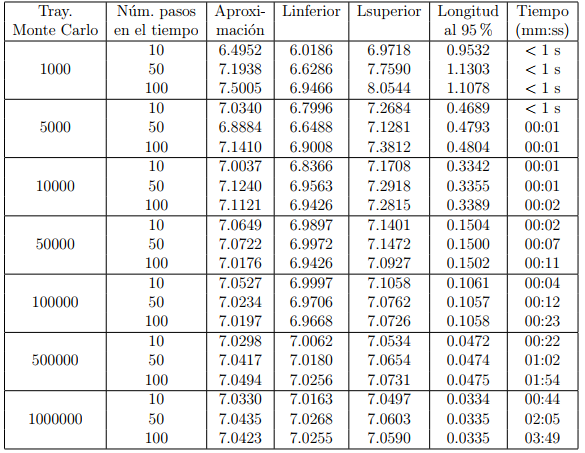

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

Se habilitará un enlace en canvas donde se adjuntará los resultados de dicha tarea

>**Nota:** Para generar índices de manera como se especifica en la tabla referirse a:
> - https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
> - https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
> - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html


#### Código de solución `ESTUDIANTE 1: FRIDA HERNÁNDEZ`

#### Código de solución `ESTUDIANTE 2: IVAN ARELLANO`

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t


# Función donde se almacenan todos los resultados
# Función Riemann.
def Riemann_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Calculamos el put de la opción según la formula obtenida para Sumas de Riemann
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start

        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p


    return St.T,t
# Reimman Trapecio 
def Riemann_Trapecio(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
        NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
        sigma:'Volatilidad',T:'Tiempo de cierre',Option_Type:'Tipo de opción',
        Trust_level:'Confianza',flag=None):
  
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    h = T / NbStep
    strike = K
    
    if Option_Type == 'Call':
        # Definimos el trapecio para el call
        Average_trapeze_c = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el call de la opción según la formula obtenida para el trapecio
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax((h/2*T) * Average_trapeze_c - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Definimos el trapecio para el put
        Average_trapeze_p = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el put de la opción según la formula obtenida para el trapecio
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - (h/2*T) * Average_trapeze_p, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start
    
        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p
    
def Trayectorias(simulacion):
    t1 = ([np.array(simulacion[i]) for i in range(len(simulacion))][0])
    t2 = ([np.array(simulacion[i]) for i in range(len(simulacion))][1])
    t3 = ([np.array(simulacion[i]) for i in range(len(simulacion))][2])
    t4 = ([np.array(simulacion[i]) for i in range(len(simulacion))][3])
    t5 = ([np.array(simulacion[i]) for i in range(len(simulacion))][4])
    t6 = ([np.array(simulacion[i]) for i in range(len(simulacion))][5])
    t7 = ([np.array(simulacion[i]) for i in range(len(simulacion))][6])
    m = np.concatenate([t1,t2,t3,t4,t5,t6,t7])
    
    return m

In [3]:
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1
N_traj_sim = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
N_step_sim = [10, 50, 100]
N_traj = [1000]*3+[5000]*3+[10000]*3+[50000]*3+[100000]*3+[500000]*3+[1000000]*3
N_step = [10,50,100]*len(set(N_traj))
index = [N_traj, N_step]

# Trapecio (Call Asiática)

In [4]:
trapecio_call_AS = [[Riemann_Trapecio(K,r,S0,j,i,sigma,T,'Call',0.95) for i in N_step_sim] for j in N_traj_sim]

In [5]:
trapecio_call = pd.DataFrame(Trayectorias(trapecio_call_AS),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Núm. pasos en el tiempo')))

In [6]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
trapecio_call

Aproximación  Linferior  \
Tray. Montecarlo Núm. pasos en el tiempo                            
1000             10                              7.004      5.632   
                 50                              6.531      6.152   
                 100                             6.516      6.265   
5000             10                              6.726      5.408   
                 50                              6.949      6.538   
                 100                             6.858      6.590   
10000            10                              6.896      5.544   
                 50                              6.881      6.475   
                 100                             7.094      6.815   
50000            10                              6.907      5.552   
                 50                              7.035      6.619   
                 100                             7.049      6.772   
100000           10                              6.954      5.589   
                 50                              7.036      6.620   
                 100                             7.010      6.735   
500000           10                              6.897      5.545   
                 50                              7.022      6.607   
                 100                             7.026      6.750   
1000000          10                              6.897      5.544   
                 50                              7.008      6.594   
                 100                             7.021      6.745   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Núm. pasos en el tiempo                               
1000             10                           8.376            2.744   
                 50                           6.909            0.757   
                 100                          6.767            0.502   
5000             10                           8.045            2.637   
                 50                           7.359            0.820   
                 100                          7.126            0.536   
10000            10                           8.249            2.705   
                 50                           7.286            0.812   
                 100                          7.373            0.557   
50000            10                           8.262            2.710   
                 50                           7.450            0.831   
                 100                          7.326            0.555   
100000           10                           8.318            2.728   
                 50                           7.452            0.832   
                 100                          7.286            0.551   
500000           10                           8.250            2.706   
                 50                           7.437            0.829   
                 100                          7.303            0.552   
1000000          10                           8.249            2.705   
                 50                           7.421            0.827   
                 100                          7.298            0.552   

                                          Tiempo (mm:ss)  
Tray. Montecarlo Núm. pasos en el tiempo                  
1000             10                                0.365  
                 50                                0.134  
                 100                               0.101  
5000             10                                0.194  
                 50                                0.343  
                 100                               0.358  
10000            10                                0.381  
                 50                                0.435  
                 100                               0.458  
50000            10                                1.761  
                 50                                2.092  
                 100          

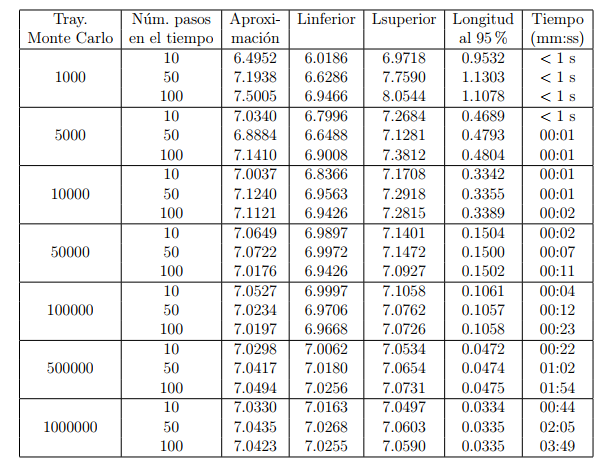

# Riemman Call Asiática

Se realizara con los mismos datos para comparar 

In [7]:
riemann_call_AS = [[Riemann_approach(K,r,S0,j,i,sigma,T,'Call', 0.95) for i in N_step_sim] for j in N_traj_sim]



In [8]:
riemann_call = pd.DataFrame(Trayectorias(riemann_call_AS),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo(mm:ss)'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Núm. pasos en el tiempo')))


In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
riemann_call 

Aproximación  Linferior  \
Tray. Montecarlo Núm. pasos en el tiempo                            
1000             10                              6.270      5.032   
                 50                              6.627      6.136   
                 100                             6.914      6.563   
5000             10                              6.319      5.065   
                 50                              7.103      6.574   
                 100                             7.008      6.646   
10000            10                              6.377      5.120   
                 50                              6.853      6.340   
                 100                             6.867      6.516   
50000            10                              6.412      5.142   
                 50                              6.907      6.391   
                 100                             6.892      6.537   
100000           10                              6.407      5.136   
                 50                              6.890      6.376   
                 100                             6.970      6.612   
500000           10                              6.411      5.141   
                 50                              6.898      6.383   
                 100                             6.977      6.617   
1000000          10                              6.418      5.146   
                 50                              6.921      6.405   
                 100                             6.982      6.622   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Núm. pasos en el tiempo                               
1000             10                           7.508            2.476   
                 50                           7.118            0.982   
                 100                          7.266            0.703   
5000             10                           7.572            2.507   
                 50                           7.631            1.057   
                 100                          7.369            0.723   
10000            10                           7.634            2.514   
                 50                           7.365            1.025   
                 100                          7.217            0.701   
50000            10                           7.682            2.540   
                 50                           7.423            1.032   
                 100                          7.246            0.710   
100000           10                           7.677            2.541   
                 50                           7.404            1.028   
                 100                          7.329            0.717   
500000           10                           7.682            2.541   
                 50                           7.412            1.029   
                 100                          7.336            0.719   
1000000          10                           7.690            2.545   
                 50                           7.438            1.033   
                 100                          7.341            0.720   

                                          Tiempo(mm:ss)  
Tray. Montecarlo Núm. pasos en el tiempo                 
1000             10                               0.097  
                 50                               0.058  
                 100                              0.060  
5000             10                               0.157  
                 50                               0.201  
                 100                              0.245  
10000            10                               0.297  
                 50                               0.357  
                 100                              0.466  
50000            10                               1.381  
                 50                               1.703  
                 100                       

# Conclusiones Call Asiatico ambos métodos: 

En cuanto a tiempo de calculo, es bastante similar y en cuanto exactitud y resultados es tambien es bastante similar los dos métodos 


**Ahora realizare el los mismos dos métodos pero para un Put:**

# Trapecio (Put Asiática):

In [10]:
trapecio_put_AS = [[Riemann_Trapecio(K,r,S0,j,i,sigma,T,'Put',0.95) for i in N_step_sim] for j in N_traj_sim]

In [11]:
trapecio_put = pd.DataFrame(Trayectorias(trapecio_put_AS),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Núm. pasos en el tiempo')))

In [12]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
trapecio_put

Aproximación  Linferior  \
Tray. Montecarlo Núm. pasos en el tiempo                            
1000             10                              2.338    -14.752   
                 50                              2.466     -4.985   
                 100                             2.297     -2.967   
5000             10                              2.268    -14.838   
                 50                              2.363     -5.091   
                 100                             2.377     -2.875   
10000            10                              2.229    -14.878   
                 50                              2.239     -5.238   
                 100                             2.357     -2.898   
50000            10                              2.194    -14.934   
                 50                              2.323     -5.141   
                 100                             2.385     -2.869   
100000           10                              2.235    -14.879   
                 50                              2.346     -5.114   
                 100                             2.359     -2.897   
500000           10                              2.228    -14.888   
                 50                              2.333     -5.129   
                 100                             2.348     -2.909   
1000000          10                              2.224    -14.894   
                 50                              2.339     -5.122   
                 100                             2.347     -2.911   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Núm. pasos en el tiempo                               
1000             10                          19.429           34.182   
                 50                           9.917           14.902   
                 100                          7.561           10.528   
5000             10                          19.375           34.213   
                 50                           9.818           14.909   
                 100                          7.630           10.505   
10000            10                          19.336           34.214   
                 50                           9.715           14.953   
                 100                          7.613           10.511   
50000            10                          19.322           34.256   
                 50                           9.787           14.928   
                 100                          7.640           10.510   
100000           10                          19.350           34.229   
                 50                           9.806           14.920   
                 100                          7.615           10.512   
500000           10                          19.345           34.233   
                 50                           9.795           14.924   
                 100                          7.605           10.514   
1000000          10                          19.342           34.235   
                 50                           9.800           14.922   
                 100                          7.604           10.515   

                                          Tiempo (mm:ss)  
Tray. Montecarlo Núm. pasos en el tiempo                  
1000             10                                0.179  
                 50                                0.185  
                 100                               0.085  
5000             10                                0.178  
                 50                                0.224  
                 100                               0.369  
10000            10                                0.427  
                 50                                0.382  
                 100                               0.553  
50000            10                                1.510  
                 50                                1.687  
                 100          

# Riemman (Put Asiática):

In [13]:
riemann_put_AS = [[Riemann_approach(K,r,S0,j,i,sigma,T,'Put',0.95) for i in N_step_sim] for j in N_traj_sim]

In [14]:
riemann_put = pd.DataFrame(Trayectorias(riemann_put_AS),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo(mm:ss)'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Núm. pasos en el tiempo')))

In [15]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
riemann_put

Aproximación  Linferior  \
Tray. Montecarlo Núm. pasos en el tiempo                            
1000             10                              2.225      1.801   
                 50                              2.228      2.088   
                 100                             2.644      2.526   
5000             10                              2.182      1.765   
                 50                              2.345      2.194   
                 100                             2.343      2.243   
10000            10                              2.275      1.839   
                 50                              2.349      2.199   
                 100                             2.303      2.206   
50000            10                              2.223      1.797   
                 50                              2.323      2.176   
                 100                             2.342      2.242   
100000           10                              2.214      1.790   
                 50                              2.330      2.182   
                 100                             2.351      2.251   
500000           10                              2.224      1.798   
                 50                              2.332      2.184   
                 100                             2.356      2.256   
1000000          10                              2.222      1.796   
                 50                              2.333      2.185   
                 100                             2.351      2.251   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Núm. pasos en el tiempo                               
1000             10                           2.649            0.849   
                 50                           2.369            0.281   
                 100                          2.761            0.235   
5000             10                           2.599            0.834   
                 50                           2.496            0.302   
                 100                          2.443            0.199   
10000            10                           2.712            0.873   
                 50                           2.499            0.300   
                 100                          2.401            0.195   
50000            10                           2.649            0.852   
                 50                           2.470            0.294   
                 100                          2.442            0.200   
100000           10                           2.639            0.848   
                 50                           2.477            0.295   
                 100                          2.450            0.199   
500000           10                           2.651            0.852   
                 50                           2.480            0.296   
                 100                          2.456            0.200   
1000000          10                           2.648            0.852   
                 50                           2.480            0.296   
                 100                          2.451            0.200   

                                          Tiempo(mm:ss)  
Tray. Montecarlo Núm. pasos en el tiempo                 
1000             10                               0.090  
                 50                               0.079  
                 100                              0.075  
5000             10                               0.194  
                 50                               0.153  
                 100                              0.225  
10000            10                               0.357  
                 50                               0.323  
                 100                              0.445  
50000            10                               1.525  
                 50                               1.647  
                 100                       

# Conclusiones Put Asiatico ambos métodos:

En cuanto a tiempo de calculo, es bastante similar y en cuanto exactitud y resultados es tambien es bastante similar los dos métodos 